# Sentiment Analysis:
## This Notebook works off of example HR data found here: https://www.kaggle.com/code/fiodarryzhykau/sentiment-analysis-of-employee-review-classic-ml/notebook
## The dataset contains the feedback text and two scores for each employee (performance and potential, both graded 0-2 or low, medium, high). To treat this multi-class text classification, we analyze the sentiment of feedback and relate it to both. 
# 

In [19]:
#import necessary libraries
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import contractions
import emoji
import re
import random

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\esrussel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\esrussel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\esrussel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\esrussel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\esrussel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\esrussel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Load datasets
train_df = pd.read_csv('train_set.csv')
val_df = pd.read_csv('validation_set.csv')
test_df = pd.read_csv('test_set.csv')

# Set index
train_df.set_index('id', inplace=True)
val_df.set_index('id', inplace=True)
test_df.set_index('id', inplace=True)

# Drop unwanted columns - not needed as we call our features and target variables specifically
#columns_to_drop = [
#    'person_name', 'nine_box_category', 'adjusted',
#    'reviewed', 'label', 'feedback_clean', 'data_type'
#]

#for df in [train_df, val_df, test_df]:
#    df.drop(columns=columns_to_drop, inplace=True)

# Define text preprocessing function, we remove stopwords, lemmatize, and edit contractions/delimiters
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = contractions.fix(text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    negations = {"not", "no", "nor", "never"}
    stop_words = set(stopwords.words('english')) - negations
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Preprocess + Add Sentiment Scores using TextBlob to pull polarity and subjectivity
for df in [train_df, val_df, test_df]:
    df['feedback_processed'] = df['feedback'].apply(preprocess_text)
    df['sentiment_polarity'] = df['feedback'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['sentiment_subjectivity'] = df['feedback'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# TF-IDF on preprocessed feedback, we already controlled stopwords above so as to not remove essential negations
tfidf = TfidfVectorizer(max_features=1000, stop_words=None)
X_train_text = tfidf.fit_transform(train_df['feedback_processed'])
X_val_text = tfidf.transform(val_df['feedback_processed'])

# Add sentiment features
X_train = np.hstack([
    X_train_text.toarray(),
    train_df[['sentiment_polarity', 'sentiment_subjectivity']].values
])
X_val = np.hstack([
    X_val_text.toarray(),
    val_df[['sentiment_polarity', 'sentiment_subjectivity']].values
])

# Labels
y_train_perf = train_df['performance_class']
y_val_perf = val_df['performance_class']
y_train_pot = train_df['potential_class']
y_val_pot = val_df['potential_class']

# Using logistic regression, model for performance_class and potential_class
model_perf = LogisticRegression(max_iter=1000)
model_perf.fit(X_train, y_train_perf)
y_pred_val_perf = model_perf.predict(X_val)
print("Performance Class Report:")
print(classification_report(y_val_perf, y_pred_val_perf))

model_pot = LogisticRegression(max_iter=1000)
model_pot.fit(X_train, y_train_pot)
y_pred_val_pot = model_pot.predict(X_val)
print("Potential Class Report:")
print(classification_report(y_val_pot, y_pred_val_pot))


Performance Class Report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        36
           1       0.79      0.75      0.77        40
           2       0.80      0.82      0.81        40

    accuracy                           0.80       116
   macro avg       0.80      0.80      0.80       116
weighted avg       0.80      0.80      0.80       116

Potential Class Report:
              precision    recall  f1-score   support

           0       0.63      0.62      0.63        42
           1       0.67      0.71      0.69        42
           2       0.73      0.69      0.71        32

    accuracy                           0.67       116
   macro avg       0.68      0.67      0.68       116
weighted avg       0.67      0.67      0.67       116



# We add RandomForest as a comparison tool against the Logistic Regression above

In [21]:
# Using random forest, model for performance_class and potential_class
rf_perf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_perf.fit(X_train, train_df['performance_class'])
y_pred_perf = rf_perf.predict(X_val)
print("Performance Class Report:")
print(classification_report(val_df['performance_class'], y_pred_perf))

rf_pot = RandomForestClassifier(n_estimators=100, random_state=42)
rf_pot.fit(X_train, train_df['potential_class'])
y_pred_pot = rf_pot.predict(X_val)
print("Potential Class Report:")
print(classification_report(val_df['potential_class'], y_pred_pot))

Performance Class Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        36
           1       0.64      0.70      0.67        40
           2       0.68      0.68      0.68        40

    accuracy                           0.68       116
   macro avg       0.69      0.68      0.68       116
weighted avg       0.68      0.68      0.68       116

Potential Class Report:
              precision    recall  f1-score   support

           0       0.61      0.67      0.64        42
           1       0.52      0.60      0.56        42
           2       0.55      0.38      0.44        32

    accuracy                           0.56       116
   macro avg       0.56      0.55      0.55       116
weighted avg       0.56      0.56      0.55       116



# Logistic Regression wins out
Logistic Regression is the better model overall for your use case, especially for predicting both Performance and Potential classes with better accuracy, class balance, and easier to explain driving features

Random Forest can be worth improving if you suspect non-linear patterns are being missed — but needs tuning to yield greater scores (e.g., max depth, number of trees).

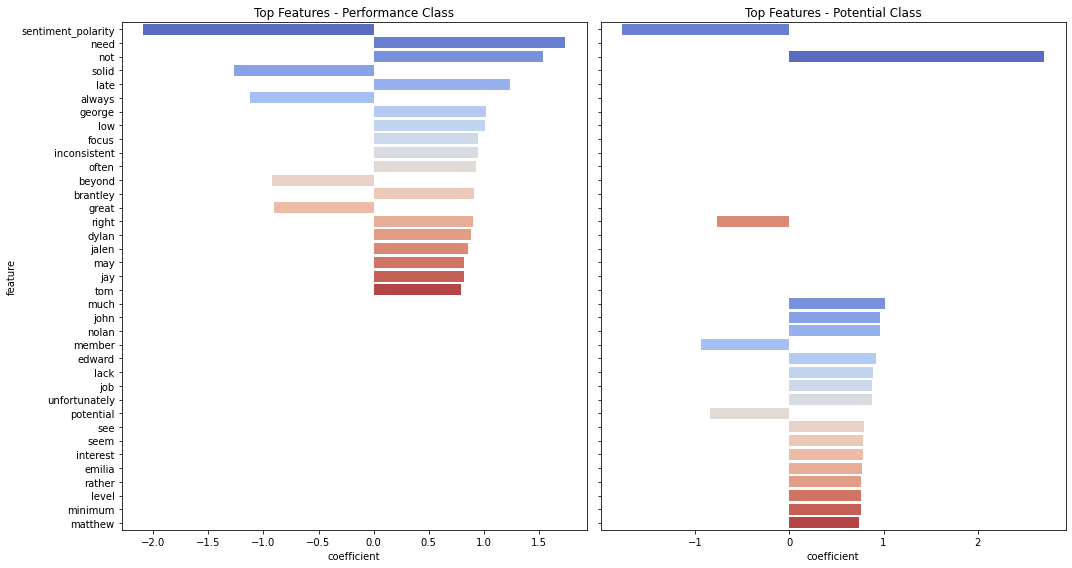

In [22]:
# Create combined feature names
feature_names = tfidf.get_feature_names_out().tolist() + ['sentiment_polarity', 'sentiment_subjectivity']

# Get coefficients
coefs_perf = model_perf.coef_[0]  # If it's one-vs-rest, choose [0] or loop
coefs_pot = model_pot.coef_[0]

# Build DataFrames
feat_df_perf = pd.DataFrame({'feature': feature_names, 'coefficient': coefs_perf})
feat_df_pot = pd.DataFrame({'feature': feature_names, 'coefficient': coefs_pot})

# Sort by absolute value of coefficients
top_perf = feat_df_perf.reindex(feat_df_perf.coefficient.abs().sort_values(ascending=False).index).head(20)
top_pot = feat_df_pot.reindex(feat_df_pot.coefficient.abs().sort_values(ascending=False).index).head(20)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

sns.barplot(x='coefficient', y='feature', data=top_perf, palette='coolwarm', ax=axes[0])
axes[0].set_title("Top Features - Performance Class")

sns.barplot(x='coefficient', y='feature', data=top_pot, palette='coolwarm', ax=axes[1])
axes[1].set_title("Top Features - Potential Class")

plt.tight_layout()
plt.show()


# Below we show the score predictability of true against real values

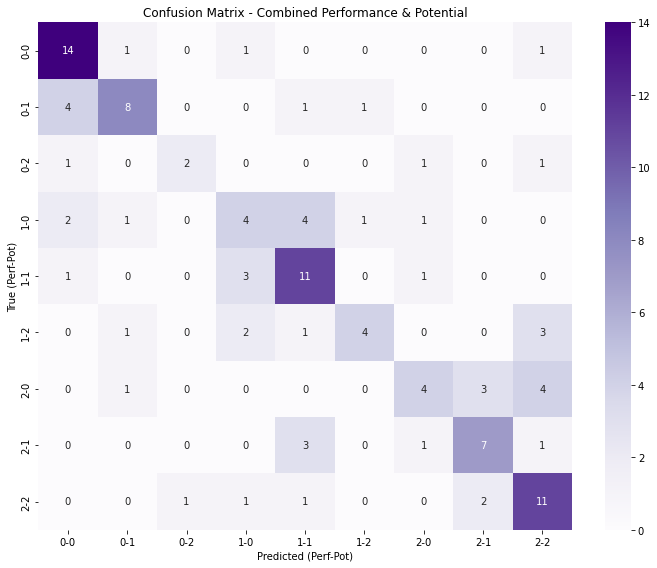

In [23]:
# Convert tuples to strings for scikit-learn compatibility
true_combo = [f"{p}-{q}" for p, q in zip(y_val_perf, y_val_pot)]
pred_combo = [f"{p}-{q}" for p, q in zip(y_pred_val_perf, y_pred_val_pot)]

# Get unique combined labels (sorted for consistent axis order)
unique_labels = sorted(set(true_combo + pred_combo))

# Confusion Matrix
cm_combo = confusion_matrix(true_combo, pred_combo, labels=unique_labels)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_combo, annot=True, fmt="d", cmap='Purples',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted (Perf-Pot)")
plt.ylabel("True (Perf-Pot)")
plt.title("Confusion Matrix - Combined Performance & Potential")
plt.tight_layout()
plt.show()


In [24]:
# Pick an example row from the validation set
random.seed(42)
idx = random.randint(0, len(val_df) - 1)

# Get feedback and predictions
feedback_text = val_df.iloc[idx]['feedback']
processed_text = val_df.iloc[idx]['feedback_processed']
pred_perf = y_pred_val_perf[idx]
pred_pot = y_pred_val_pot[idx]

# Map positional idx to actual index label
actual_index = val_df.index[idx]
real_perf = y_val_perf.loc[actual_index]
real_pot = y_val_pot.loc[actual_index]

print("📋 Raw Feedback:")
print(feedback_text)
print(f"\n🔮 Predicted Performance Class: {pred_perf}, Real Performance Class: {real_perf}")
print(f"🔮 Predicted Potential Class:    {pred_pot}, Real Potential Class: {real_pot}")


📋 Raw Feedback:
Finley Gray has been an asset to our company as he always completes tasks as assigned to him.  As soon as Mr Gray gets to work he begins his day, he is never idle.  Finley works until his job is complete and is proud of his results. Finley is detail oriented and also makes sure his assignments are completed perfectly.

🔮 Predicted Performance Class: 2, Real Performance Class: 2
🔮 Predicted Potential Class:    1, Real Potential Class: 1
